# 00__motifs

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sys

from scipy.stats import spearmanr

# import utils
sys.path.append("../../../utils")
from plotting_utils import *
from misc_utils import *
from norm_utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

In [3]:
np.random.seed(2019)

## variables

In [4]:
data_dir = "../../../data/02__mpra/02__activs"
human_max_f = "%s/human_TSS_vals.max_tile.txt" % data_dir
mouse_max_f = "%s/mouse_TSS_vals.max_tile.txt" % data_dir

In [5]:
results_dir = "../../../data/02__mpra/03__results"
results_f = "%s/native_cis_trans_effects_data.txt" % results_dir

In [6]:
motif_info_dir = "../../../misc/02__motif_info"
motif_map_f = "%s/00__lambert_et_al_files/00__metadata/curated_motif_map.txt" % motif_info_dir

In [7]:
motif_dir = "../../../data/04__mapped_motifs"
human_motifs_f = "%s/hg19_human_curated_tfs_out/fimo.txt.gz" % motif_dir
mouse_motifs_f = "%s/mm9_human_curated_tfs_out/fimo.txt.gz" % motif_dir

In [8]:
expr_dir = "../../../data/03__rna_seq/04__TF_expr"
orth_expr_f = "%s/orth_TF_expression.txt" % expr_dir
human_expr_f = "%s/hESC_TF_expression.txt" % expr_dir
mouse_expr_f = "%s/mESC_TF_expression.txt" % expr_dir

In [9]:
orth_f = "../../../misc/01__ensembl_orthologs/ensembl96_human_mouse_orths.txt.gz"

## 1. import data

In [10]:
results = pd.read_table(results_f, sep="\t")
results.head()

,chr_tss_hg19,start_tss_hg19,end_tss_hg19,strand_tss_hg19,cage_id_hg19,biotype_hg19,name_peak_hg19,seq_orth,cage_orth,chr_tss_mm9,...,trans_status_detail_human,fdr_trans_mouse,logFC_trans_mouse,abs_logFC_trans_mouse,trans_status_mouse,trans_status_detail_mouse,trans_status_one,trans_status_detail_one,logFC_trans_max,abs_logFC_trans_max
0,chr1,2985430,2985431,-,"chr1:2985420..2985438,-",div_lnc,ENSG00000177133.6,True,True,chr4,...,no trans effect,0.585918,-0.384559,0.384559,no trans effect,no trans effect,no trans effect,no trans effect,-0.384559,0.384559
1,chr1,8086552,8086553,+,"chr1:8086546..8086571,+",div_lnc,ENSG00000238290.1,True,True,chr4,...,no trans effect,0.492102,0.500227,0.500227,no trans effect,no trans effect,no trans effect,no trans effect,1.300086,1.300086
2,chr1,26498322,26498323,-,"chr1:26498321..26498327,-",antisense_upep,ENSG00000236782.1,True,True,chr4,...,no trans effect,0.902393,-0.088485,0.088485,no trans effect,no trans effect,no trans effect,no trans effect,0.443366,0.443366
3,chr1,65533428,65533429,-,"chr1:65533390..65533443,-",intergenic,ENSG00000231485.1,True,True,chr4,...,no trans effect,0.311051,0.460589,0.460589,no trans effect,no trans effect,no trans effect,no trans effect,0.460589,0.460589
4,chr1,65533462,65533463,-,"chr1:65533457..65533465,-",intergenic,ENSG00000231485.1,True,True,chr4,...,no trans effect,0.375934,0.447387,0.447387,no trans effect,no trans effect,no trans effect,no trans effect,0.447387,0.447387


In [11]:
human_max = pd.read_table(human_max_f, sep="\t")
mouse_max = pd.read_table(mouse_max_f, sep="\t")
human_max.head()

,element,tss_id,biotype_hg19,tss_tile_num,HUES64,HUES64_log,HUES64_padj,HUES64_sig,cleaner_biotype
0,GCCCTCTCGCCCCGCCCTTGCCCAGGCAGCCCCCGGTCGCGACGGC...,h.999,div_pc,tile2,0.588526,-0.230235,1.848145e-02,sig,mRNA
1,GGGCGGGACGGAGACTCTGGGCTCAAGGCTCCTGGAAATGGGCGGG...,h.998,div_pc,tile2,0.885958,-0.052587,1.044316e-06,sig,mRNA
2,AAAAGGCAGTGCTTGATTCAATTCAACATTCACTGCGCCACTTACC...,h.997,div_pc,tile2,0.423129,-0.373527,2.996315e-01,not sig,mRNA
3,CGGAGGGGCGGGGCAAGAGTGGGAGGAGACCCTGCGCGCGGCCGCC...,h.996,div_pc,tile2,2.452145,0.389546,5.019212e-74,sig,mRNA
4,AGGGTGGTGCGTGGTCTACGGCGAGCGGAGTGGGGCGGGGTCGCGC...,h.995,div_pc,tile1,0.994045,-0.002594,6.400385e-09,sig,mRNA


In [12]:
motif_map = pd.read_table(motif_map_f)
motif_map.head()

,index,gene_id,gene_name
0,HKR1,ENSG00000181666,HKR1
1,M00117_1,ENSG00000137203,TFAP2A
2,M00118_1,ENSG00000137203,TFAP2A
3,M00119_1,ENSG00000137203,TFAP2A
4,M00120_1,ENSG00000137203,TFAP2A


In [13]:
human_motifs = pd.read_table(human_motifs_f, sep="\t")
human_motifs.head()

,#pattern name,sequence name,start,stop,strand,score,p-value,q-value,matched sequence
0,ZNF212,HUMAN_EVO_TSS__h.3519__tile2;WT::chr7:47680526...,5,34,+,55.8485,7.500000e-19,2.850000e-13,gagagagagagagagagagagagagagaga
1,ZNF212,HUMAN_EVO_TSS__h.3519__tile2;WT::chr7:47680526...,7,36,+,55.8485,7.500000e-19,2.850000e-13,gagagagagagagagagagagagagagaga
2,ZNF212,HUMAN_EVO_TSS__h.3519__tile2;WT::chr7:47680526...,9,38,+,55.8485,7.500000e-19,2.850000e-13,gagagagagagagagagagagagagagaga
3,ZNF212,HUMAN_EVO_TSS__h.3519__tile2;WT::chr7:47680526...,11,40,+,55.8485,7.500000e-19,2.850000e-13,gagagagagagagagagagagagagagaga
4,ZNF212,HUMAN_EVO_TSS__h.357__tile2;WT::chr8:65285637-...,43,72,+,52.5051,5.310000e-18,1.150000e-12,gagagagagagagagagagaaagagagaga


In [14]:
mouse_motifs = pd.read_table(mouse_motifs_f, sep="\t")
mouse_motifs.head()

,#pattern name,sequence name,start,stop,strand,score,p-value,q-value,matched sequence
0,ZNF212,MOUSE_EVO_TSS__m.2482__tile2;WT::chr4:9214553-...,1,30,+,55.8485,7.500000e-19,7.970000e-15,gagagagagagagagagagagagagagaga
1,ZNF212,MOUSE_EVO_TSS__m.2482__tile2;WT::chr4:9214553-...,3,32,+,55.8485,7.500000e-19,7.970000e-15,gagagagagagagagagagagagagagaga
2,ZNF212,MOUSE_EVO_TSS__m.2482__tile2;WT::chr4:9214553-...,5,34,+,55.8485,7.500000e-19,7.970000e-15,gagagagagagagagagagagagagagaga
3,ZNF212,MOUSE_EVO_TSS__m.315__tile1;WT::chr18:7003691-...,9,38,+,55.8485,7.500000e-19,7.970000e-15,gagagagagagagagagagagagagagaga
4,ZNF212,MOUSE_EVO_TSS__m.315__tile1;WT::chr18:7003691-...,11,40,+,55.8485,7.500000e-19,7.970000e-15,gagagagagagagagagagagagagagaga


In [15]:
orth_expr = pd.read_table(orth_expr_f, sep="\t")
orth_expr.head()

,gene_id_human,gene_name_human,mean_tpm_human,gene_id_mouse,gene_name_mouse,mean_tpm_mouse,baseMean,log2FoldChange,lfcSE,padj,sig
0,ENSG00000197921,HES5,101.620874,ENSMUSG00000048001,Hes5,0.000000,42.463063,9.220488,1.288307,1.707594e-12,sig
1,ENSG00000069812,HES2,30.322266,ENSMUSG00000028940,Hes2,11.737072,19.474793,1.493640,0.690207,3.923633e-02,not sig
2,ENSG00000204859,ZBTB48,699.343307,ENSMUSG00000028952,Zbtb48,958.237804,847.501906,-0.344481,0.129711,1.067351e-02,not sig
3,ENSG00000009709,PAX7,240.239581,ENSMUSG00000028736,Pax7,8.372211,105.367706,4.965287,0.503225,1.561741e-22,sig
4,ENSG00000125945,ZNF436,322.236851,ENSMUSG00000051351,Zfp46,659.764959,517.530217,-0.927220,0.204617,9.467015e-06,not sig


In [16]:
human_expr = pd.read_table(human_expr_f, sep="\t")
human_expr.head()

,index,gene_name,mean_tpm
0,ENSG00000197921,HES5,101.620874
1,ENSG00000069812,HES2,30.322266
2,ENSG00000204859,ZBTB48,699.343307
3,ENSG00000009709,PAX7,240.239581
4,ENSG00000125945,ZNF436,322.236851


In [17]:
mouse_expr = pd.read_table(mouse_expr_f, sep="\t")
mouse_expr.head()

,gene_id_human,gene_name_human,gene_id_mouse,gene_name_mouse,mean_tpm_mouse
0,ENSG00000197921,HES5,ENSMUSG00000048001,Hes5,0.000000
1,ENSG00000069812,HES2,ENSMUSG00000028940,Hes2,11.737072
2,ENSG00000204859,ZBTB48,ENSMUSG00000028952,Zbtb48,958.237804
3,ENSG00000009709,PAX7,ENSMUSG00000028736,Pax7,8.372211
4,ENSG00000125945,ZNF436,ENSMUSG00000051351,Zfp46,659.764959


In [18]:
orth = pd.read_table(orth_f, sep="\t")
orth.head()

,Gene stable ID,Transcript stable ID,Gene name,Mouse gene stable ID,Mouse protein or transcript stable ID,Mouse gene name,%id. target Mouse gene identical to query gene,%id. query gene identical to target Mouse gene,"Mouse orthology confidence [0 low, 1 high]",Mouse homology type
0,ENSG00000198888,ENST00000361390,MT-ND1,ENSMUSG00000064341,ENSMUSP00000080991,mt-Nd1,77.0440,77.0440,1.0,ortholog_one2one
1,ENSG00000198763,ENST00000361453,MT-ND2,ENSMUSG00000064345,ENSMUSP00000080992,mt-Nd2,57.0605,57.3913,1.0,ortholog_one2one
2,ENSG00000198804,ENST00000361624,MT-CO1,ENSMUSG00000064351,ENSMUSP00000080993,mt-Co1,90.8382,90.6615,1.0,ortholog_one2one
3,ENSG00000198712,ENST00000361739,MT-CO2,ENSMUSG00000064354,ENSMUSP00000080994,mt-Co2,71.3656,71.3656,1.0,ortholog_one2one
4,ENSG00000228253,ENST00000361851,MT-ATP8,ENSMUSG00000064356,ENSMUSP00000080995,mt-Atp8,45.5882,46.2687,0.0,ortholog_one2one


## 2. parse motif files

In [19]:
human_motifs = human_motifs.merge(motif_map, left_on="#pattern name", right_on="index", how="left")
human_motifs["hg19_id"] = human_motifs["sequence name"].str.split("__", expand=True)[1]
human_motifs["tile_num"] = human_motifs["sequence name"].str.split(";", expand=True)[0].str.split("__", expand=True)[2]
human_motifs["tss_strand"] = human_motifs["sequence name"].str[-2]
human_motifs.sample(5)

,#pattern name,sequence name,start,stop,strand,score,p-value,q-value,matched sequence,index,gene_id,gene_name,hg19_id,tile_num,tss_strand
2718182,M00586_1,HUMAN_EVO_TSS__h.390__tile2;WT::chrX:134555763...,60,70,-,11.2857,0.000087,0.2970,CCACCCCCCCG,M00586_1,ENSG00000126603,GLIS2,h.390,tile2,+
652395,M06498_1,HUMAN_EVO_TSS__h.268__tile2;WT::chr4:16228057-...,121,131,+,13.4490,0.000012,0.0124,ccgccgccgcc,M06498_1,ENSG00000120738,EGR1,h.268,tile2,+
2069975,M07530_1,HUMAN_EVO_TSS__h.386__tile1;WT::chrX:110754758...,83,91,-,11.2653,0.000060,1.0000,GAGATAAGA,M07530_1,ENSG00000102145,GATA1,h.386,tile1,+
575717,M08998_1,HUMAN_EVO_TSS__h.3546__tile2;WT::chr18:3411813...,109,116,+,10.6429,0.000010,0.3940,GGGGTCAC,M08998_1,ENSG00000120798,NR2C1,h.3546,tile2,-
2491430,M02987_1,HUMAN_EVO_TSS__h.1637__tile1;WT::chr9:77114360...,99,108,-,11.0816,0.000077,0.0476,TGGGGGAGGG,M02987_1,ENSG00000164651,SP8,h.1637,tile1,-


In [20]:
mouse_motifs = mouse_motifs.merge(motif_map, left_on="#pattern name", right_on="index", how="left")
mouse_motifs["mm9_id"] = mouse_motifs["sequence name"].str.split("__", expand=True)[1]
mouse_motifs["tss_strand"] = mouse_motifs["sequence name"].str[-2]
mouse_motifs["tile_num"] = mouse_motifs["sequence name"].str.split(";", expand=True)[0].str.split("__", expand=True)[2]
mouse_motifs.sample(5)

,#pattern name,sequence name,start,stop,strand,score,p-value,q-value,matched sequence,index,gene_id,gene_name,mm9_id,tss_strand,tile_num
1625667,M00561_1,MOUSE_EVO_TSS__m.2410__tile1;WT::chr11:1050424...,62,71,-,10.4228,0.000051,0.0819,CGCCCCCGAG,M00561_1,ENSG00000120738,EGR1,m.2410,-,tile1
341173,M08605_1,MOUSE_EVO_TSS__m.1655__tile2;WT::chr6:95668774...,32,44,-,14.6122,0.000006,0.0243,TCCGCCCCCTCCC,M08605_1,ENSG00000120738,EGR1,m.1655,+,tile2
617276,M05957_1,MOUSE_EVO_TSS__m.2323__tile2;WT::chr8:93393271...,11,24,+,12.2347,0.000013,0.2830,TGGCTCAAAGTTCA,M05957_1,ENSG00000160113,NR2F6,m.2323,+,tile2
1837076,M05274_1,MOUSE_EVO_TSS__m.2067__tile2;WT::chr12:5659297...,109,123,+,10.0816,0.000061,0.1140,ggcggcggagggcgg,M05274_1,ENSG00000102974,CTCF,m.2067,-,tile2
1557477,M09546_1,MOUSE_EVO_TSS__m.745__tile1;WT::chr7:29965659-...,94,104,-,11.7959,0.000048,0.1830,GAACGGAAGTC,M09546_1,ENSG00000126767,ELK1,m.745,-,tile1


In [21]:
# limit motif tiles to those that are max tiles (since we mapped motifs in both tiles)
human_max_motifs = human_max.merge(human_motifs, left_on=["tss_id", "tss_tile_num"],
                                   right_on=["hg19_id", "tile_num"], how="left").reset_index()
human_max_motifs = human_max_motifs[~pd.isnull(human_max_motifs["element"])]
human_max_motifs.head()

,level_0,element,tss_id,biotype_hg19,tss_tile_num,HUES64,HUES64_log,HUES64_padj,HUES64_sig,cleaner_biotype,...,score,p-value,q-value,matched sequence,index,gene_id,gene_name,hg19_id,tile_num,tss_strand
0,0,GCCCTCTCGCCCCGCCCTTGCCCAGGCAGCCCCCGGTCGCGACGGC...,h.999,div_pc,tile2,0.588526,-0.230235,0.018481,sig,mRNA,...,19.0367,9.940000e-08,0.000098,GGGCAAGGGCGGGGCGAGAG,M06783_1,ENSG00000185591,SP1,h.999,tile2,+
1,1,GCCCTCTCGCCCCGCCCTTGCCCAGGCAGCCCCCGGTCGCGACGGC...,h.999,div_pc,tile2,0.588526,-0.230235,0.018481,sig,mRNA,...,19.0367,2.410000e-07,0.000520,CCAGGGCCGCCGCCC,ZNF519,ENSG00000175322,ZNF519,h.999,tile2,+
2,2,GCCCTCTCGCCCCGCCCTTGCCCAGGCAGCCCCCGGTCGCGACGGC...,h.999,div_pc,tile2,0.588526,-0.230235,0.018481,sig,mRNA,...,18.2857,2.460000e-07,0.000586,GGGCAAGGGCGGGGC,M03053_1,ENSG00000185591,SP1,h.999,tile2,+
3,3,GCCCTCTCGCCCCGCCCTTGCCCAGGCAGCCCCCGGTCGCGACGGC...,h.999,div_pc,tile2,0.588526,-0.230235,0.018481,sig,mRNA,...,17.6429,2.860000e-07,0.000805,GGGGCAGGCGCGAGGAGCGGC,M10427_1,ENSG00000131061,ZNF341,h.999,tile2,+
4,4,GCCCTCTCGCCCCGCCCTTGCCCAGGCAGCCCCCGGTCGCGACGGC...,h.999,div_pc,tile2,0.588526,-0.230235,0.018481,sig,mRNA,...,18.1414,3.480000e-07,0.000311,GGGCAAGGGCGGGGCGAGAGG,M07126_1,ENSG00000181444,ZNF467,h.999,tile2,+


In [22]:
# limit motif tiles to those that are max tiles (since we mapped motifs in both tiles)
mouse_max_motifs = mouse_max.merge(mouse_motifs, left_on=["tss_id", "tss_tile_num"],
                                   right_on=["mm9_id", "tile_num"], how="left").reset_index()
mouse_max_motifs = mouse_max_motifs[~pd.isnull(mouse_max_motifs["element"])]
mouse_max_motifs.head()

,level_0,element,tss_id,biotype_mm9,tss_tile_num,mESC,mESC_log,mESC_padj,mESC_sig,cleaner_biotype,...,score,p-value,q-value,matched sequence,index,gene_id,gene_name,mm9_id,tss_strand,tile_num
0,0,GGGGGTTGGTGGCGGCGAGGTGGAGATGCTAGAAAAGGGCGGGACC...,m.999,div_pc,tile1,2.43217,0.385994,5.320842e-37,sig,mRNA,...,22.5918,3.220000e-09,0.00136,CGCCAAGATGGCGGC,M05478_1,ENSG00000100811,YY1,m.999,-,tile1
1,1,GGGGGTTGGTGGCGGCGAGGTGGAGATGCTAGAAAAGGGCGGGACC...,m.999,div_pc,tile1,2.43217,0.385994,5.320842e-37,sig,mRNA,...,21.9388,1.710000e-08,0.00208,CAAGATGGCGGCG,M05491_1,ENSG00000100811,YY1,m.999,-,tile1
2,2,GGGGGTTGGTGGCGGCGAGGTGGAGATGCTAGAAAAGGGCGGGACC...,m.999,div_pc,tile1,2.43217,0.385994,5.320842e-37,sig,mRNA,...,21.2347,2.040000e-08,0.00156,CAAGATGGCGGCGCT,M05355_1,ENSG00000100811,YY1,m.999,-,tile1
3,3,GGGGGTTGGTGGCGGCGAGGTGGAGATGCTAGAAAAGGGCGGGACC...,m.999,div_pc,tile1,2.43217,0.385994,5.320842e-37,sig,mRNA,...,21.5204,2.180000e-08,0.00109,CAAGATGGCGGCGCT,M05442_1,ENSG00000100811,YY1,m.999,-,tile1
4,4,GGGGGTTGGTGGCGGCGAGGTGGAGATGCTAGAAAAGGGCGGGACC...,m.999,div_pc,tile1,2.43217,0.385994,5.320842e-37,sig,mRNA,...,21.0510,2.340000e-08,0.00168,CAAGATGGCGGCGCT,M05321_1,ENSG00000100811,YY1,m.999,-,tile1


## 3. find motifs enriched in trans effects

### human sequences
[since we have to look at motifs in each sequence separately, analyze them separately]

In [23]:
uniq_human_tfs = human_max_motifs["gene_name"].unique()
len(uniq_human_tfs)

921

In [24]:
results.trans_status_detail_human.value_counts()

no trans effect                    3195
trans effect\n(higher in human)      59
trans effect\n(higher in mouse)      25
Name: trans_status_detail_human, dtype: int64

In [25]:
human_trans_results = {}
for i, tf in enumerate(uniq_human_tfs):
    if i % 50 == 0:
        print(i)
        
    # do directional analysis: first, high in human
    sub_motifs = human_max_motifs[human_max_motifs["gene_name"] == tf]["hg19_id"].unique()
    
    sub_trans = results[results["trans_status_detail_human"] == "trans effect\n(higher in human)"]["hg19_id"].unique()
    sub_no_trans = results[results["trans_status_detail_human"] != "trans effect\n(higher in human)"]["hg19_id"].unique()
    
    n_hu_trans_w_motif = len([x for x in sub_trans if x in sub_motifs])
    n_hu_trans_wo_motif = len([x for x in sub_trans if x not in sub_motifs])
    n_hu_no_trans_w_motif = len([x for x in sub_no_trans if x in sub_motifs])
    n_hu_no_trans_wo_motif = len([x for x in sub_no_trans if x not in sub_motifs])
    
    arr = np.zeros((2, 2))
    arr[0, 0] = n_hu_trans_w_motif
    arr[0, 1] = n_hu_trans_wo_motif
    arr[1, 0] = n_hu_no_trans_w_motif
    arr[1, 1] = n_hu_no_trans_wo_motif
    
    hu_odds, hu_p = stats.fisher_exact(arr)
    
    # next, high in mouse
    sub_trans = results[results["trans_status_detail_human"] == "trans effect\n(higher in mouse)"]["hg19_id"].unique()
    sub_no_trans = results[results["trans_status_detail_human"] != "trans effect\n(higher in mouse)"]["hg19_id"].unique()
    
    n_mo_trans_w_motif = len([x for x in sub_trans if x in sub_motifs])
    n_mo_trans_wo_motif = len([x for x in sub_trans if x not in sub_motifs])
    n_mo_no_trans_w_motif = len([x for x in sub_no_trans if x in sub_motifs])
    n_mo_no_trans_wo_motif = len([x for x in sub_no_trans if x not in sub_motifs])
    
    arr = np.zeros((2, 2))
    arr[0, 0] = n_mo_trans_w_motif
    arr[0, 1] = n_mo_trans_wo_motif
    arr[1, 0] = n_mo_no_trans_w_motif
    arr[1, 1] = n_mo_no_trans_wo_motif
    
    mo_odds, mo_p = stats.fisher_exact(arr)
    human_trans_results[tf] = {"high_in_HUES64_odds": hu_odds, "high_in_HUES64_pval": hu_p, 
                               "n_high_in_HUES64_trans_w_motif": n_hu_trans_w_motif, 
                               "n_high_in_HUES64_trans_wo_motif": n_hu_trans_wo_motif, 
                               "n_no_high_in_HUES64_trans_w_motif": n_hu_no_trans_w_motif,
                               "n_no_high_in_HUES64_trans_wo_motif": n_hu_no_trans_wo_motif,
                               "high_in_mESC_odds": mo_odds, "high_in_mESC_pval": mo_p, 
                               "n_high_in_mESC_trans_w_motif": n_mo_trans_w_motif, 
                               "n_high_in_mESC_trans_wo_motif": n_mo_trans_wo_motif, 
                               "n_no_high_in_mESC_trans_w_motif": n_mo_no_trans_w_motif,
                               "n_no_high_in_mESC_trans_wo_motif": n_mo_no_trans_wo_motif}
    
human_trans_results = pd.DataFrame.from_dict(human_trans_results, orient="index").reset_index()
human_trans_results.sort_values(by="high_in_HUES64_pval").head()

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900


,index,high_in_HUES64_odds,high_in_HUES64_pval,n_high_in_HUES64_trans_w_motif,n_high_in_HUES64_trans_wo_motif,n_no_high_in_HUES64_trans_w_motif,n_no_high_in_HUES64_trans_wo_motif,high_in_mESC_odds,high_in_mESC_pval,n_high_in_mESC_trans_w_motif,n_high_in_mESC_trans_wo_motif,n_no_high_in_mESC_trans_w_motif,n_no_high_in_mESC_trans_wo_motif
267,JDP2,5.672479,3.223818e-07,17,39,225,2928,1.066667,0.712703,2,23,240,2944
568,VSX1,5.221749,4.406360e-05,11,45,141,3012,3.907336,0.028135,4,21,148,3036
28,BATF,4.020217,4.957908e-05,15,41,263,2890,2.022941,0.268464,4,21,274,2910
268,JUN,3.065132,6.497393e-05,26,30,695,2458,1.090467,0.811983,6,19,715,2469
136,FOSL2,3.276968,2.648261e-04,16,40,343,2810,0.688588,1.000000,2,23,357,2827


In [26]:
human_trans_results["high_in_HUES64_padj"] = multicomp.multipletests(human_trans_results["high_in_HUES64_pval"], method="fdr_bh")[1]
len(human_trans_results[human_trans_results["high_in_HUES64_padj"] < 0.05])

8

In [27]:
human_trans_results["high_in_mESC_padj"] = multicomp.multipletests(human_trans_results["high_in_mESC_pval"], method="fdr_bh")[1]
len(human_trans_results[human_trans_results["high_in_mESC_padj"] < 0.05])

0

In [28]:
list(human_trans_results[human_trans_results["high_in_HUES64_padj"] < 0.05]["index"])

['BATF', 'ESX1', 'FOSL2', 'JDP2', 'JUN', 'LBX2', 'SOX1', 'VSX1']

### mouse sequences

In [29]:
uniq_mouse_tfs = mouse_max_motifs["gene_name"].unique()
len(uniq_mouse_tfs)

921

In [30]:
results.trans_status_detail_mouse.value_counts()

no trans effect                    3190
trans effect\n(higher in mouse)      58
trans effect\n(higher in human)      31
Name: trans_status_detail_mouse, dtype: int64

In [31]:
mouse_trans_results = {}
for i, tf in enumerate(uniq_mouse_tfs):
    if i % 50 == 0:
        print(i)
        
    # do directional analysis: first, high in human
    sub_motifs = mouse_max_motifs[mouse_max_motifs["gene_name"] == tf]["mm9_id"].unique()
    
    sub_trans = results[results["trans_status_detail_mouse"] == "trans effect\n(higher in human)"]["mm9_id"].unique()
    sub_no_trans = results[results["trans_status_detail_mouse"] != "trans effect\n(higher in human)"]["mm9_id"].unique()
    
    n_hu_trans_w_motif = len([x for x in sub_trans if x in sub_motifs])
    n_hu_trans_wo_motif = len([x for x in sub_trans if x not in sub_motifs])
    n_hu_no_trans_w_motif = len([x for x in sub_no_trans if x in sub_motifs])
    n_hu_no_trans_wo_motif = len([x for x in sub_no_trans if x not in sub_motifs])
    
    arr = np.zeros((2, 2))
    arr[0, 0] = n_hu_trans_w_motif
    arr[0, 1] = n_hu_trans_wo_motif
    arr[1, 0] = n_hu_no_trans_w_motif
    arr[1, 1] = n_hu_no_trans_wo_motif
    
    hu_odds, hu_p = stats.fisher_exact(arr)
    
    # next, high in mouse
    sub_trans = results[results["trans_status_detail_mouse"] == "trans effect\n(higher in mouse)"]["mm9_id"].unique()
    sub_no_trans = results[results["trans_status_detail_mouse"] != "trans effect\n(higher in mouse)"]["mm9_id"].unique()
    
    n_mo_trans_w_motif = len([x for x in sub_trans if x in sub_motifs])
    n_mo_trans_wo_motif = len([x for x in sub_trans if x not in sub_motifs])
    n_mo_no_trans_w_motif = len([x for x in sub_no_trans if x in sub_motifs])
    n_mo_no_trans_wo_motif = len([x for x in sub_no_trans if x not in sub_motifs])
    
    arr = np.zeros((2, 2))
    arr[0, 0] = n_mo_trans_w_motif
    arr[0, 1] = n_mo_trans_wo_motif
    arr[1, 0] = n_mo_no_trans_w_motif
    arr[1, 1] = n_mo_no_trans_wo_motif
    
    mo_odds, mo_p = stats.fisher_exact(arr)
    mouse_trans_results[tf] = {"high_in_HUES64_odds": hu_odds, "high_in_HUES64_pval": hu_p, 
                               "n_high_in_HUES64_trans_w_motif": n_hu_trans_w_motif, 
                               "n_high_in_HUES64_trans_wo_motif": n_hu_trans_wo_motif, 
                               "n_no_high_in_HUES64_trans_w_motif": n_hu_no_trans_w_motif,
                               "n_no_high_in_HUES64_trans_wo_motif": n_hu_no_trans_wo_motif,
                               "high_in_mESC_odds": mo_odds, "high_in_mESC_pval": mo_p, 
                               "n_high_in_mESC_trans_w_motif": n_mo_trans_w_motif, 
                               "n_high_in_mESC_trans_wo_motif": n_mo_trans_wo_motif, 
                               "n_no_high_in_mESC_trans_w_motif": n_mo_no_trans_w_motif,
                               "n_no_high_in_mESC_trans_wo_motif": n_mo_no_trans_wo_motif}
    
mouse_trans_results = pd.DataFrame.from_dict(mouse_trans_results, orient="index").reset_index()
mouse_trans_results.sort_values(by="high_in_mESC_pval").head()

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900


,index,high_in_HUES64_odds,high_in_HUES64_pval,n_high_in_HUES64_trans_w_motif,n_high_in_HUES64_trans_wo_motif,n_no_high_in_HUES64_trans_w_motif,n_no_high_in_HUES64_trans_wo_motif,high_in_mESC_odds,high_in_mESC_pval,n_high_in_mESC_trans_w_motif,n_high_in_mESC_trans_wo_motif,n_no_high_in_mESC_trans_w_motif,n_no_high_in_mESC_trans_wo_motif
308,MEIS3,0.000000,0.407296,0,30,168,2877,4.669827,0.000114,11,43,157,2866
307,MEIS2,0.000000,0.640549,0,30,135,2910,4.598413,0.000456,9,45,126,2897
369,NR2C2,3.196429,0.006658,9,21,360,2685,2.890574,0.001230,15,39,355,2668
731,ZNF394,0.853261,0.829833,6,24,690,2355,0.197776,0.001448,3,51,693,2330
479,SNAI2,0.759334,0.807000,4,26,513,2532,2.529058,0.002655,18,36,499,2524


In [32]:
mouse_trans_results["high_in_HUES64_padj"] = multicomp.multipletests(mouse_trans_results["high_in_HUES64_pval"], method="fdr_bh")[1]
len(mouse_trans_results[mouse_trans_results["high_in_HUES64_padj"] < 0.05])

4

In [33]:
mouse_trans_results["high_in_mESC_padj"] = multicomp.multipletests(mouse_trans_results["high_in_mESC_pval"], method="fdr_bh")[1]
len(mouse_trans_results[mouse_trans_results["high_in_mESC_padj"] < 0.05])

0

In [34]:
list(mouse_trans_results[mouse_trans_results["high_in_HUES64_padj"] < 0.05]["index"])

['DDIT3', 'FOXK1', 'MAFF', 'SOX3']

## 4. plot trans enrichment results

In [35]:
sig_human = human_trans_results[human_trans_results["high_in_HUES64_padj"] < 0.05][["index", "high_in_HUES64_odds"]].set_index("index")
sig_human = sig_human.sort_values(by="high_in_HUES64_odds", ascending=False)
sig_human

,high_in_HUES64_odds
index,
LBX2,7.762500
ESX1,7.298824
JDP2,5.672479
VSX1,5.221749
BATF,4.020217
FOSL2,3.276968
JUN,3.065132
SOX1,3.061264


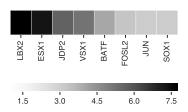

In [36]:
grid_kws = {"height_ratios": (.75, .25), "hspace": 3}
f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws, figsize=(3, 1.5))
ax = sns.heatmap(sig_human.T, ax=ax, cbar_ax=cbar_ax, cbar_kws={"orientation": "horizontal"}, cmap="Greys", 
                 linewidth=0.25, xticklabels=sig_human.index, yticklabels="", vmin=1)
ax.set_xlabel("")
f.savefig("trans_motif_enrichments.human_high_in_HUES64.pdf", dpi="figure", bbox_inches="tight")

In [37]:
sig_mouse = mouse_trans_results[mouse_trans_results["high_in_HUES64_padj"] < 0.05][["index", "high_in_HUES64_odds"]].set_index("index")
sig_mouse = sig_mouse.sort_values(by="high_in_HUES64_odds", ascending=False)
sig_mouse

,high_in_HUES64_odds
index,
DDIT3,7.896883
FOXK1,6.926829
SOX3,5.632353
MAFF,4.348448


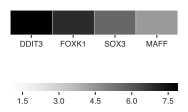

In [38]:
grid_kws = {"height_ratios": (.75, .25), "hspace": 3}
f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws, figsize=(3, 1.5))
ax = sns.heatmap(sig_mouse.T, ax=ax, cbar_ax=cbar_ax, cbar_kws={"orientation": "horizontal"}, cmap="Greys", 
                 linewidth=0.25, xticklabels=sig_mouse.index, yticklabels="", vmin=1)
ax.set_xlabel("")
f.savefig("trans_motif_enrichments.mouse_high_in_HUES64.pdf", dpi="figure", bbox_inches="tight")

In [39]:
sig_both = sig_human.append(sig_mouse)
sig_both = sig_both.sort_values(by="high_in_HUES64_odds", ascending=False)

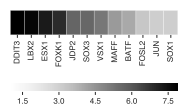

In [40]:
grid_kws = {"height_ratios": (.75, .25), "hspace": 3}
f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws, figsize=(3, 1.5))
ax = sns.heatmap(sig_both.T, ax=ax, cbar_ax=cbar_ax, cbar_kws={"orientation": "horizontal"}, cmap="Greys", 
                 linewidth=0.25, xticklabels=sig_both.index, yticklabels="", vmin=1)
ax.set_xlabel("")
f.savefig("trans_motif_enrichments.high_in_HUES64.pdf", dpi="figure", bbox_inches="tight")

In [49]:
sig_human = human_trans_results[human_trans_results["high_in_HUES64_padj"] < 0.05][["index", "high_in_HUES64_odds", "high_in_HUES64_padj"]]
sig_mouse = mouse_trans_results[mouse_trans_results["high_in_HUES64_padj"] < 0.05][["index", "high_in_HUES64_odds", "high_in_HUES64_padj"]]
sig_both_plt = sig_human.append(sig_mouse)
sig_both_plt = sig_both_plt.sort_values(by="high_in_HUES64_odds", ascending=False)
sig_both_plt["neg_log10_padj"] = -np.log10(sig_both_plt["high_in_HUES64_padj"])
sig_both_plt["xticks"] = list(range(len(sig_both_plt)))[::-1]
sig_both_plt

,index,high_in_HUES64_odds,high_in_HUES64_padj,neg_log10_padj,xticks
68,DDIT3,7.896883,0.025680,1.590398,11
280,LBX2,7.762500,0.044684,1.349849,10
121,ESX1,7.298824,0.045225,1.344619,9
151,FOXK1,6.926829,0.009071,2.042362,8
267,JDP2,5.672479,0.000297,3.527370,7
491,SOX3,5.632353,0.009071,2.042362,6
568,VSX1,5.221749,0.014960,1.825061,5
294,MAFF,4.348448,0.025680,1.590398,4
28,BATF,4.020217,0.014960,1.825061,3
136,FOSL2,3.276968,0.044684,1.349849,2


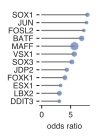

In [63]:
fig = plt.figure(figsize=(0.9, 1.75))

ax = sns.scatterplot(data=sig_both_plt, y="xticks", x="high_in_HUES64_odds", size="neg_log10_padj", 
                     color=sns.color_palette("Set2")[2], **{"linewidths": 0.5, "edgecolors": "white"},
                     sizes=(20, 80), legend=False)

for i, row in sig_both_plt.iterrows():
    xmax = row.high_in_HUES64_odds
    y = row.xticks
    ax.plot([0, xmax], [y, y], color="gray")
    
ax.set_yticks(np.arange(len(sig_both_plt["index"])))
ax.set_yticklabels(sig_both_plt["index"])
ax.set_ylabel("")
ax.set_xlabel("odds ratio")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

#plt.legend(loc=2, bbox_to_anchor=(1.25, 0.5))

## 5. plot trans effect sizes for each motif

In [64]:
human_max_motifs_sub = human_max_motifs[["hg19_id", "gene_name"]].drop_duplicates()
mouse_max_motifs_sub = mouse_max_motifs[["mm9_id", "gene_name"]].drop_duplicates()

In [65]:
results.columns

Index(['chr_tss_hg19', 'start_tss_hg19', 'end_tss_hg19', 'strand_tss_hg19',
       'cage_id_hg19', 'biotype_hg19', 'name_peak_hg19', 'seq_orth',
       'cage_orth', 'chr_tss_mm9', 'start_tss_mm9', 'end_tss_mm9',
       'strand_tss_mm9', 'cage_id_mm9', 'biotype_mm9', 'name_peak_mm9',
       'avg_exp_hg19', 'avg_exp_mm9', 'stem_exp_hg19', 'stem_exp_mm9', 'har',
       'oligo_type', 'hg19_id', 'mm9_id', 'cleaner_biotype_hg19',
       'cleaner_biotype_mm9', 'biotype_switch', 'biotype_switch_clean',
       'hg19_element', 'mm9_element', 'HUES64_hg19', 'mESC_hg19',
       'HUES64_pval_hg19', 'mESC_pval_hg19', 'HUES64_padj_hg19',
       'mESC_padj_hg19', 'HUES64_mm9', 'mESC_mm9', 'HUES64_pval_mm9',
       'mESC_pval_mm9', 'HUES64_padj_mm9', 'mESC_padj_mm9', 'fdr_native',
       'logFC_native', 'abs_logFC_native', 'native_status',
       'native_status_detail', 'native_status_complete', 'fdr_cis_HUES64',
       'logFC_cis_HUES64', 'abs_logFC_cis_HUES64', 'cis_status_HUES64',
       'cis_status

BATF
# w/ motif: 288, # w/o: 2991
0.0471785077418


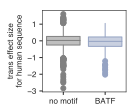

ESX1
# w/ motif: 57, # w/o: 3222
0.604466749388


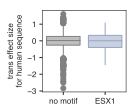

FOSL2
# w/ motif: 371, # w/o: 2908
0.0562626230852


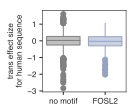

JDP2
# w/ motif: 258, # w/o: 3021
0.000106271122219


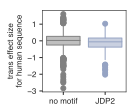

JUN
# w/ motif: 744, # w/o: 2535
0.594179069618


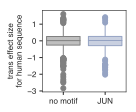

LBX2
# w/ motif: 54, # w/o: 3225
0.382831423961


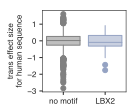

SOX1
# w/ motif: 418, # w/o: 2861
0.00561517170134


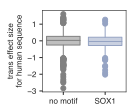

VSX1
# w/ motif: 155, # w/o: 3124
0.406623960627


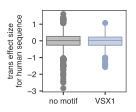

In [66]:
# plot trans effects of each motif +/- individually
sig_human = sig_human.reset_index()
for sig_tf in sig_human["index"].unique():
    print(sig_tf)
    
    sub_motif_ids = human_max_motifs[human_max_motifs["gene_name"] == sig_tf]["hg19_id"].unique()
    data_w_motif = results[results["hg19_id"].isin(sub_motif_ids)]
    data_no_motif = results[~results["hg19_id"].isin(sub_motif_ids)]
    print("# w/ motif: %s, # w/o: %s" % (len(data_w_motif), len(data_no_motif)))
    
    data_w_motif["motif_status"] = sig_tf
    data_no_motif["motif_status"] = "no motif"
    tmp = data_w_motif.append(data_no_motif)
    
    # calc p-vals b/w dists
    dist1 = np.asarray(data_w_motif["logFC_trans_human"])
    dist2 = np.asarray(data_no_motif["logFC_trans_human"])

    dist1 = dist1[~np.isnan(dist1)]
    dist2 = dist2[~np.isnan(dist2)]

    u, pval = stats.mannwhitneyu(dist1, dist2, alternative="two-sided", use_continuity=False)
    print(pval)
    
    # boxplot
    fig, ax = plt.subplots(figsize=(1.5, 1.5), nrows=1, ncols=1)
    order = ["no motif", sig_tf]
    pal = {"no motif": "gray", sig_tf: sns.color_palette("Set2")[2]}
    sns.boxplot(data=tmp, x="motif_status", y="logFC_trans_human", ax=ax, order=order, palette=pal,
                flierprops = dict(marker='o', markersize=5), linewidth=1)
    mimic_r_boxplot(ax)
    ax.set_xlabel("")
    ax.set_ylabel("trans effect size\nfor human sequence")
    plt.show()
    fig.savefig("%s_trans_effect_boxplot.pdf" % sig_tf, dpi="figure", bbox_inches="tight")

DDIT3
# w/ motif: 129, # w/o: 3150
0.00267699428435


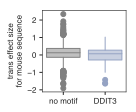

FOXK1
# w/ motif: 226, # w/o: 3053
0.725439017381


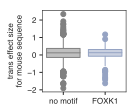

MAFF
# w/ motif: 769, # w/o: 2510
0.0393469689168


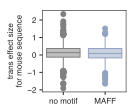

SOX3
# w/ motif: 398, # w/o: 2881
0.000316469180368


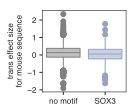

In [67]:
# plot trans effects of each motif +/- individually
sig_mouse = sig_mouse.reset_index()
for sig_tf in sig_mouse["index"].unique():
    print(sig_tf)
    
    sub_motif_ids = mouse_max_motifs[mouse_max_motifs["gene_name"] == sig_tf]["mm9_id"].unique()
    data_w_motif = results[results["mm9_id"].isin(sub_motif_ids)]
    data_no_motif = results[~results["mm9_id"].isin(sub_motif_ids)]
    print("# w/ motif: %s, # w/o: %s" % (len(data_w_motif), len(data_no_motif)))
    
    data_w_motif["motif_status"] = sig_tf
    data_no_motif["motif_status"] = "no motif"
    tmp = data_w_motif.append(data_no_motif)
    
    # calc p-vals b/w dists
    dist1 = np.asarray(data_w_motif["logFC_trans_mouse"])
    dist2 = np.asarray(data_no_motif["logFC_trans_mouse"])

    dist1 = dist1[~np.isnan(dist1)]
    dist2 = dist2[~np.isnan(dist2)]

    u, pval = stats.mannwhitneyu(dist1, dist2, alternative="two-sided", use_continuity=False)
    print(pval)
    
    # boxplot
    fig, ax = plt.subplots(figsize=(1.5, 1.5), nrows=1, ncols=1)
    order = ["no motif", sig_tf]
    pal = {"no motif": "gray", sig_tf: sns.color_palette("Set2")[2]}
    sns.boxplot(data=tmp, x="motif_status", y="logFC_trans_mouse", ax=ax, order=order, palette=pal,
                flierprops = dict(marker='o', markersize=5), linewidth=1)
    mimic_r_boxplot(ax)
    ax.set_xlabel("")
    ax.set_ylabel("trans effect size\nfor mouse sequence")
    plt.show()
    fig.savefig("%s_trans_effect_boxplot.pdf" % sig_tf, dpi="figure", bbox_inches="tight")

## 6. examine expression changes related to trans effects

In [68]:
len(orth_expr)

686

In [69]:
trans_tfs = list(sig_both.reset_index()["index"])
print(len(trans_tfs))
trans_tfs

12


['DDIT3',
 'LBX2',
 'ESX1',
 'FOXK1',
 'JDP2',
 'SOX3',
 'VSX1',
 'MAFF',
 'BATF',
 'FOSL2',
 'JUN',
 'SOX1']

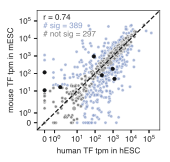

In [70]:
fig, ax = plt.subplots(figsize=(2.2, 2.2), nrows=1, ncols=1)

sig = orth_expr[orth_expr["sig"] == "sig"]
not_sig = orth_expr[orth_expr["sig"] == "not sig"]
trans_sig = sig[sig["gene_name_human"].isin(trans_tfs)]
trans_not_sig = not_sig[not_sig["gene_name_human"].isin(trans_tfs)]

ax.scatter(sig["mean_tpm_human"], 
           sig["mean_tpm_mouse"],
           color=sns.color_palette("Set2")[2], alpha=0.75, s=10, 
           linewidths=0.5, edgecolors="white")

ax.scatter(not_sig["mean_tpm_human"], 
           not_sig["mean_tpm_mouse"],
           color="gray", alpha=0.9, s=10, 
           linewidths=0.5, edgecolors="white")

ax.scatter(trans_sig["mean_tpm_human"], 
           trans_sig["mean_tpm_mouse"],
           color="black", alpha=0.9, s=12, 
           linewidths=0.5, edgecolors="black")

ax.scatter(trans_not_sig["mean_tpm_human"], 
           trans_not_sig["mean_tpm_mouse"],
           color="darkgray", alpha=0.9, s=12, 
           linewidths=0.5, edgecolors="darkgray")

ax.set_xscale("symlog")
ax.set_yscale("symlog")
ax.plot([-0.75, 400000], [-0.75, 400000], "k", linestyle="dashed")
ax.set_xlim((-0.75, 400000))
ax.set_ylim((-0.75, 400000))

ax.set_xlabel("human TF tpm in hESC")
ax.set_ylabel("mouse TF tpm in mESC")

# annotate corr
no_nan = orth_expr[(~pd.isnull(orth_expr["mean_tpm_human"])) & 
                   (~pd.isnull(orth_expr["mean_tpm_mouse"]))]
r, p = spearmanr(no_nan["mean_tpm_human"], no_nan["mean_tpm_mouse"])
ax.text(0.05, 0.97, "r = {:.2f}".format(r), ha="left", va="top", fontsize=fontsize,
        transform=ax.transAxes)
ax.text(0.05, 0.90, "# sig = %s" % (len(sig)), ha="left", va="top", fontsize=fontsize, 
        color=sns.color_palette("Set2")[2],
        transform=ax.transAxes)
ax.text(0.05, 0.83, "# not sig = %s" % (len(not_sig)), ha="left", va="top", fontsize=fontsize, color="gray",
        transform=ax.transAxes)
fig.savefig("TF_human_v_mouse_scatter.w_trans_outline.pdf", dpi="figure", bbox_inches="tight")

## 6. plot expression changes and % ID

In [71]:
orth_sub = orth[["Gene stable ID", "Gene name", "Mouse gene stable ID", "Mouse gene name", "Mouse homology type",
                 "%id. target Mouse gene identical to query gene", "%id. query gene identical to target Mouse gene"]]
orth_sub.columns = ["gene_id_human", "gene_name_human", "gene_id_mouse", "gene_name_mouse", "homology_type",
                    "perc_mouse_to_human", "perc_human_to_mouse"]
orth_sub.head()

,gene_id_human,gene_name_human,gene_id_mouse,gene_name_mouse,homology_type,perc_mouse_to_human,perc_human_to_mouse
0,ENSG00000198888,MT-ND1,ENSMUSG00000064341,mt-Nd1,ortholog_one2one,77.0440,77.0440
1,ENSG00000198763,MT-ND2,ENSMUSG00000064345,mt-Nd2,ortholog_one2one,57.0605,57.3913
2,ENSG00000198804,MT-CO1,ENSMUSG00000064351,mt-Co1,ortholog_one2one,90.8382,90.6615
3,ENSG00000198712,MT-CO2,ENSMUSG00000064354,mt-Co2,ortholog_one2one,71.3656,71.3656
4,ENSG00000228253,MT-ATP8,ENSMUSG00000064356,mt-Atp8,ortholog_one2one,45.5882,46.2687


In [72]:
orth_expr = orth_expr.merge(orth_sub, on=["gene_id_human", "gene_name_human", "gene_id_mouse", "gene_name_mouse"],
                            how="left")
orth_expr.sample(5)

,gene_id_human,gene_name_human,mean_tpm_human,gene_id_mouse,gene_name_mouse,mean_tpm_mouse,baseMean,log2FoldChange,lfcSE,padj,sig,homology_type,perc_mouse_to_human,perc_human_to_mouse
1315,ENSG00000113580,NR3C1,669.621942,ENSMUSG00000024431,Nr3c1,907.028550,804.933399,-0.330597,0.235269,1.911241e-01,not sig,ortholog_one2one,89.3316,87.7525
4862,ENSG00000198185,ZNF334,1143.287521,ENSMUSG00000017667,Zfp334,171.758611,576.424562,2.842042,0.136328,1.276589e-95,sig,ortholog_one2one,64.1536,66.4212
619,ENSG00000179528,LBX2,6.837294,ENSMUSG00000034968,Lbx2,1.463507,3.713119,2.379192,1.684482,1.889155e-01,not sig,ortholog_one2one,76.7677,77.9487
3453,ENSG00000166949,SMAD3,2008.610062,ENSMUSG00000032402,Smad3,1792.441637,1878.474152,0.272881,0.094749,5.484739e-03,not sig,ortholog_one2one,100.0000,100.0000
3348,ENSG00000169926,KLF13,3368.719072,ENSMUSG00000052040,Klf13,4683.499939,4123.523602,-0.367337,0.068718,1.576180e-07,not sig,ortholog_one2one,92.0139,91.6955


In [73]:
orth_expr = orth_expr.drop_duplicates()

In [74]:
avg_log2FoldChange = orth_expr.log2FoldChange.mean()
print(avg_log2FoldChange)
avg_perc_mouse_to_human = orth_expr.perc_mouse_to_human.mean()
print(avg_perc_mouse_to_human)
avg_perc_human_to_mouse = orth_expr.perc_human_to_mouse.mean()
print(avg_perc_human_to_mouse)

0.732617348461
86.4301626385
86.9949081633


In [75]:
trans_log2FoldChange = orth_expr[orth_expr["gene_name_human"].isin(trans_tfs)][["gene_name_human", 
                                                                                "log2FoldChange"]].set_index("gene_name_human")
trans_perc_mouse_to_human = orth_expr[orth_expr["gene_name_human"].isin(trans_tfs)][["gene_name_human", 
                                                                                "perc_mouse_to_human"]].set_index("gene_name_human")
trans_perc_human_to_mouse = orth_expr[orth_expr["gene_name_human"].isin(trans_tfs)][["gene_name_human", 
                                                                                "perc_human_to_mouse"]].set_index("gene_name_human")

trans_log2FoldChange

,log2FoldChange
gene_name_human,
JUN,0.994225
FOSL2,1.693529
LBX2,2.379192
FOXK1,0.071807
DDIT3,-3.346959
SOX1,2.473250
JDP2,-0.318680
BATF,-5.784421
VSX1,-3.346789


In [76]:
log2FoldChange = trans_log2FoldChange.append(pd.DataFrame.from_dict({"average": {"log2FoldChange": avg_log2FoldChange}}, 
                                                                    orient="index")).reset_index()
perc_mouse_to_human = trans_perc_mouse_to_human.append(pd.DataFrame.from_dict({"average": {"perc_mouse_to_human": avg_perc_mouse_to_human}}, 
                                                                    orient="index")).reset_index()
perc_human_to_mouse = trans_perc_human_to_mouse.append(pd.DataFrame.from_dict({"average": {"perc_human_to_mouse": avg_perc_human_to_mouse}}, 
                                                                    orient="index")).reset_index()
log2FoldChange

,index,log2FoldChange
0,JUN,0.994225
1,FOSL2,1.693529
2,LBX2,2.379192
3,FOXK1,0.071807
4,DDIT3,-3.346959
5,SOX1,2.473250
6,JDP2,-0.318680
7,BATF,-5.784421
8,VSX1,-3.346789
9,MAFF,0.827783


In [77]:
ordered_trans_tfs = list(log2FoldChange.sort_values(by="log2FoldChange", ascending=False)["index"])
ordered_trans_tfs.pop(ordered_trans_tfs.index('average'))
ordered_trans_tfs

['SOX3',
 'SOX1',
 'LBX2',
 'FOSL2',
 'JUN',
 'MAFF',
 'FOXK1',
 'JDP2',
 'VSX1',
 'DDIT3',
 'BATF',
 'ESX1']

In [78]:
pal = {k:sns.color_palette("Set2")[2] for k in trans_tfs}
pal["average"] = "gray"

order = ["average"]
order.extend(ordered_trans_tfs)

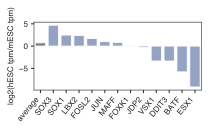

In [79]:
fig = plt.figure(figsize=(3, 1.25))

ax = sns.barplot(data=log2FoldChange, x="index", y="log2FoldChange", order=order, palette=pal)
ax.set_xlabel("")
ax.set_ylabel("log2(hESC tpm/mESC tpm)")
_ = ax.set_xticklabels(order, rotation=50, ha='right', va='top')
fig.savefig("log2FoldChange_trans_tfs.pdf", dpi="figure", bbox_inches="tight")

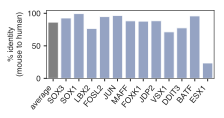

In [80]:
fig = plt.figure(figsize=(3, 1.25))

ax = sns.barplot(data=perc_mouse_to_human, x="index", y="perc_mouse_to_human", order=order, palette=pal)
ax.set_xlabel("")
ax.set_ylabel("% identity\n(mouse to human)")
_ = ax.set_xticklabels(order, rotation=50, ha='right', va='top')
fig.savefig("perc_mouse_to_human_trans_tfs.pdf", dpi="figure", bbox_inches="tight")

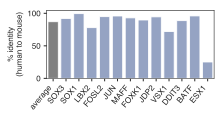

In [81]:
fig = plt.figure(figsize=(3, 1.25))

ax = sns.barplot(data=perc_human_to_mouse, x="index", y="perc_human_to_mouse", order=order, palette=pal)
ax.set_xlabel("")
ax.set_ylabel("% identity\n(human to mouse)")
_ = ax.set_xticklabels(order, rotation=50, ha='right', va='top')
fig.savefig("perc_human_to_mouse_trans_tfs.pdf", dpi="figure", bbox_inches="tight")

In [84]:
df = sig_both_plt.merge(log2FoldChange, on="index", how="left")
df

,index,high_in_HUES64_odds,high_in_HUES64_padj,neg_log10_padj,xticks,log2FoldChange
0,DDIT3,7.896883,0.025680,1.590398,11,-3.346959
1,LBX2,7.762500,0.044684,1.349849,10,2.379192
2,ESX1,7.298824,0.045225,1.344619,9,-9.185906
3,FOXK1,6.926829,0.009071,2.042362,8,0.071807
4,JDP2,5.672479,0.000297,3.527370,7,-0.318680
5,SOX3,5.632353,0.009071,2.042362,6,4.690999
6,VSX1,5.221749,0.014960,1.825061,5,-3.346789
7,MAFF,4.348448,0.025680,1.590398,4,0.827783
8,BATF,4.020217,0.014960,1.825061,3,-5.784421
9,FOSL2,3.276968,0.044684,1.349849,2,1.693529


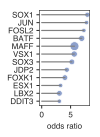

In [97]:
fig = plt.figure(figsize=(0.9, 1.75))

ax = sns.scatterplot(data=sig_both_plt, y="xticks", x="high_in_HUES64_odds", size="neg_log10_padj", 
                     color=sns.color_palette("Set2")[2], **{"linewidths": 0.5, "edgecolors": "white"},
                     sizes=(20, 80), legend=False)

for i, row in sig_both_plt.iterrows():
    xmax = row.high_in_HUES64_odds
    y = row.xticks
    ax.plot([0, xmax], [y, y], color="gray")
    
ax.set_yticks(np.arange(len(sig_both_plt["index"])))
ax.set_yticklabels(sig_both_plt["index"])
ax.set_ylabel("")
ax.set_xlabel("odds ratio")

# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.spines['left'].set_visible(False)

fig.savefig("odds_plot_lollipop.pdf", dpi="figure", bbox_inches="tight")

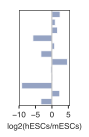

In [98]:
fig = plt.figure(figsize=(0.9, 1.75))

ax = sns.barplot(data=df, y="index", x="log2FoldChange", order=sig_both_plt["index"][::-1],
                 color=sns.color_palette("Set2")[2])

ax.axvline(x=0, color="gray", linewidth=0.5)

ax.set_yticks([])
ax.set_yticklabels([])
# _ = ax.set_yticklabels(sig_both_plt["index"][::-1])
ax.set_ylabel("")
ax.set_xlabel("log2(hESCs/mESCs)")

# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.spines['left'].set_visible(False)

fig.savefig("l2fc_plot_vert.pdf", dpi="figure", bbox_inches="tight")

## 7. find enrichment of trans motifs in enhancers

In [68]:
# # hypergeometric
# enh_results = {}
# for i, tf in enumerate(uniq_human_tfs):
#     if i % 50 == 0:
#         print(i)
        
#     # look for enrichment of this motif in either human or mouse eRNAs
#     sub_human_motifs = list(human_max_motifs[human_max_motifs["gene_name"] == tf]["hg19_id"].unique())
#     sub_mouse_motifs = list(mouse_max_motifs[mouse_max_motifs["gene_name"] == tf]["mm9_id"].unique())
    
#     sub_human_enhs = list(results[results["cleaner_biotype_hg19"] == "eRNA"]["hg19_id"].unique())
#     sub_mouse_enhs = list(results[results["cleaner_biotype_mm9"] == "eRNA"]["mm9_id"].unique())
    
#     sub_human_no_enhs = list(results[results["cleaner_biotype_hg19"] != "eRNA"]["hg19_id"].unique())
#     sub_mouse_no_enhs = list(results[results["cleaner_biotype_mm9"] != "eRNA"]["mm9_id"].unique())
    
#     # variable still called human but includes both human & mouse IDs
#     sub_human_motifs.extend(sub_mouse_motifs)
#     sub_human_enhs.extend(sub_mouse_enhs)
#     sub_human_no_enhs.extend(sub_mouse_no_enhs)
    
#     n_enh_w_motif = len([x for x in sub_human_enhs if x in sub_human_motifs])
#     n_enh_wo_motif = len([x for x in sub_human_enhs if x not in sub_human_motifs])
#     n_no_enh_w_motif = len([x for x in sub_human_no_enhs if x in sub_human_motifs])
#     n_no_enh_wo_motif = len([x for x in sub_human_no_enhs if x not in sub_human_motifs])
    

    
#     pval = stats.hypergeom.sf(n_enh_w_motif-1, n_enh_w_motif+n_enh_wo_motif+n_no_enh_w_motif+n_no_enh_wo_motif, 
#                               n_enh_w_motif+n_enh_wo_motif, n_enh_w_motif+n_no_enh_w_motif)
    
#     enh_results[tf] = {"high_in_enh_pval": p, 
#                        "n_enh_w_motif": n_enh_w_motif, 
#                        "n_enh_wo_motif": n_enh_wo_motif, 
#                        "n_no_enh_w_motif": n_no_enh_w_motif,  
#                        "n_no_enh_wo_motif": n_no_enh_wo_motif}
    
# enh_results = pd.DataFrame.from_dict(enh_results, orient="index").reset_index()
# enh_results.sort_values(by="high_in_enh_pval").head()

In [69]:
enh_results = {}
for i, tf in enumerate(uniq_human_tfs):
    if i % 50 == 0:
        print(i)
        
    # look for enrichment of this motif in either human or mouse eRNAs
    sub_human_motifs = list(human_max_motifs[human_max_motifs["gene_name"] == tf]["hg19_id"].unique())
    sub_mouse_motifs = list(mouse_max_motifs[mouse_max_motifs["gene_name"] == tf]["mm9_id"].unique())
    
    sub_human_enhs = list(results[results["cleaner_biotype_hg19"] == "eRNA"]["hg19_id"].unique())
    sub_mouse_enhs = list(results[results["cleaner_biotype_mm9"] == "eRNA"]["mm9_id"].unique())
    
    sub_human_no_enhs = list(results[results["cleaner_biotype_hg19"] != "eRNA"]["hg19_id"].unique())
    sub_mouse_no_enhs = list(results[results["cleaner_biotype_mm9"] != "eRNA"]["mm9_id"].unique())
    
    # variable still called human but includes both human & mouse IDs
    sub_human_motifs.extend(sub_mouse_motifs)
    sub_human_enhs.extend(sub_mouse_enhs)
    sub_human_no_enhs.extend(sub_mouse_no_enhs)
    
    n_enh_w_motif = len([x for x in sub_human_enhs if x in sub_human_motifs])
    n_enh_wo_motif = len([x for x in sub_human_enhs if x not in sub_human_motifs])
    n_no_enh_w_motif = len([x for x in sub_human_no_enhs if x in sub_human_motifs])
    n_no_enh_wo_motif = len([x for x in sub_human_no_enhs if x not in sub_human_motifs])
    
    arr = np.zeros((2, 2))
    arr[0, 0] = n_enh_w_motif
    arr[0, 1] = n_enh_wo_motif
    arr[1, 0] = n_no_enh_w_motif
    arr[1, 1] = n_no_enh_wo_motif
    
    odds, p = stats.fisher_exact(arr, alternative="greater")
    
    enh_results[tf] = {"high_in_enh_odds": odds, "high_in_enh_pval": p, 
                       "n_enh_w_motif": n_enh_w_motif, 
                       "n_enh_wo_motif": n_enh_wo_motif, 
                       "n_no_enh_w_motif": n_no_enh_w_motif,  
                       "n_no_enh_wo_motif": n_no_enh_wo_motif}
    
enh_results = pd.DataFrame.from_dict(enh_results, orient="index").reset_index()
enh_results.sort_values(by="high_in_enh_pval").head()

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900


,index,high_in_enh_odds,high_in_enh_pval,n_enh_w_motif,n_enh_wo_motif,n_no_enh_w_motif,n_no_enh_wo_motif
28,BATF,3.139246,1.272208e-28,195,1023,290,4776
24,BACH1,2.194041,1.998083e-24,340,878,760,4306
136,FOSL2,2.494287,5.223981e-22,216,1002,403,4663
343,NFE2,2.188487,1.234398e-21,290,928,633,4433
268,JUN,1.778758,2.176457e-15,371,847,1001,4065


In [70]:
enh_results["high_in_enh_padj"] = multicomp.multipletests(enh_results["high_in_enh_pval"], method="fdr_bh")[1]
len(enh_results[enh_results["high_in_enh_padj"] < 0.05])

208

In [71]:
enh_results[enh_results["index"].isin(ordered_trans_tfs)]

,index,high_in_enh_odds,high_in_enh_pval,n_enh_w_motif,n_enh_wo_motif,n_no_enh_w_motif,n_no_enh_wo_motif,high_in_enh_padj
28,BATF,3.139246,1.272208e-28,195,1023,290,4776,1.171703e-25
68,DDIT3,1.163404,1.743609e-01,60,1158,216,4850,4.248539e-01
121,ESX1,1.614867,2.090332e-02,30,1188,78,4988,8.262643e-02
136,FOSL2,2.494287,5.223981e-22,216,1002,403,4663,1.603762e-19
151,FOXK1,1.504440,5.018015e-04,104,1114,296,4770,3.984131e-03
267,JDP2,2.280851,3.086484e-13,141,1077,275,4791,3.158502e-11
268,JUN,1.778758,2.176457e-15,371,847,1001,4065,4.009034e-13
280,LBX2,1.335697,1.068652e-01,30,1188,94,4972,3.000696e-01
294,MAFF,1.350258,2.159062e-05,345,873,1147,3919,2.485620e-04
480,SOX1,1.775480,1.166359e-10,218,1000,554,4512,7.161446e-09


In [72]:
tmp = enh_results[enh_results["index"].isin(ordered_trans_tfs)]
tmp[tmp['high_in_enh_padj'] < 0.05]

,index,high_in_enh_odds,high_in_enh_pval,n_enh_w_motif,n_enh_wo_motif,n_no_enh_w_motif,n_no_enh_wo_motif,high_in_enh_padj
28,BATF,3.139246,1.272208e-28,195,1023,290,4776,1.171703e-25
136,FOSL2,2.494287,5.223981e-22,216,1002,403,4663,1.603762e-19
151,FOXK1,1.504440,5.018015e-04,104,1114,296,4770,3.984131e-03
267,JDP2,2.280851,3.086484e-13,141,1077,275,4791,3.158502e-11
268,JUN,1.778758,2.176457e-15,371,847,1001,4065,4.009034e-13
294,MAFF,1.350258,2.159062e-05,345,873,1147,3919,2.485620e-04
480,SOX1,1.775480,1.166359e-10,218,1000,554,4512,7.161446e-09
491,SOX3,1.493173,9.952057e-06,190,1028,558,4508,1.309406e-04
568,VSX1,1.517310,2.117447e-03,75,1143,210,4856,1.291502e-02
